[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/ML-AI-for-the-Working-Analyst/blob/main/semana6/Survival_Analysis.ipynb)

In [ ]:
# Puede necesitar instalar alguna de estas librerías, solo descomentenlas a necesidad

# !pip install lifelines
# !pip install plotly==4.14.3

### Objetivo

Implementar el análisis de supervivencia a datos sobre prestamos, para esto veremos:
  1. Estimador Kaplan Meier
  2. Modelo de Cox
  3. Mención de Survival Random Forest

### Carga

In [ ]:
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns 

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Los datos de los prestamos pueden ser encontrados [aquí](https://www.kaggle.com/datasets/yousuf28/prosper-loan). La parte de las etiquetas fue obtenida [aquí](https://github.com/ketra21/prosperloan/blob/master/Prosper%20Loan%20Data%20-%20Variable%20Definitions.csv).

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana6/prosperLoanData.csv')
df_dict = pd.read_csv('/content/drive/MyDrive/Curso-WorkingAnalyst/semana6/Prosper Loan Data - Variable Definitions.csv')

In [ ]:
df_dict.head()

,Variable,Description
0,ListingKey,"Unique key for each listing, same value as the..."
1,ListingNumber,The number that uniquely identifies the listin...
2,ListingCreationDate,The date the listing was created.
3,CreditGrade,The Credit rating that was assigned at the tim...
4,Term,The length of the loan expressed in months.


In [ ]:
df_dict_reindex = df_dict.set_index('Variable')

In [ ]:
df_dict_reindex

,Description
Variable,
ListingKey,"Unique key for each listing, same value as the..."
ListingNumber,The number that uniquely identifies the listin...
ListingCreationDate,The date the listing was created.
CreditGrade,The Credit rating that was assigned at the tim...
Term,The length of the loan expressed in months.
...,...
PercentFunded,Percent the listing was funded.
Recommendations,Number of recommendations the borrower had at ...
InvestmentFromFriendsCount,Number of friends that made an investment in t...


In [ ]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

#### Filtrando columnas

In [ ]:
df_dict_reindex.loc[['LoanKey', 'ProsperRating (numeric)', 'EmploymentStatusDuration',
                    'LoanOriginationDate', 'LoanStatus', 'EmploymentStatus',
                    'ClosedDate', 'Occupation', 'BorrowerState', 'IsBorrowerHomeowner',
                    'StatedMonthlyIncome', 'IncomeRange', 'LoanOriginalAmount'],:]

,Description
Variable,
LoanKey,Unique key for each loan. This is the same key...
ProsperRating (numeric),The Prosper Rating assigned at the time the l...
EmploymentStatusDuration,The length in months of the employment status ...
LoanOriginationDate,The date the loan was originated.
LoanStatus,"The current status of the loan: Cancelled, Ch..."
EmploymentStatus,The employment status of the borrower at the t...
ClosedDate,"Closed date is applicable for Cancelled, Compl..."
Occupation,The Occupation selected by the Borrower at the...
BorrowerState,The two letter abbreviation of the state of th...


In [ ]:
df_sub = df.loc[:, ['LoanKey', 'ProsperRating (numeric)', 'EmploymentStatusDuration',
                    'LoanOriginationDate', 'LoanStatus', 'EmploymentStatus',
                    'ClosedDate', 'Occupation', 'BorrowerState', 'IsBorrowerHomeowner',
                    'StatedMonthlyIncome', 'IncomeRange', 'LoanOriginalAmount']]
df_sub.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12 00:00:00,Completed,Self-employed,2009-08-14 00:00:00,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03 00:00:00,Current,Employed,NaN,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17 00:00:00,Completed,Not available,2009-12-17 00:00:00,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01 00:00:00,Current,Employed,NaN,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20 00:00:00,Current,Employed,NaN,Executive,MN,True,9583.333333,"$100,000+",15000


In [ ]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   LoanKey                   113937 non-null  object 
 1   ProsperRating (numeric)   84853 non-null   float64
 2   EmploymentStatusDuration  106312 non-null  float64
 3   LoanOriginationDate       113937 non-null  object 
 4   LoanStatus                113937 non-null  object 
 5   EmploymentStatus          111682 non-null  object 
 6   ClosedDate                55089 non-null   object 
 7   Occupation                110349 non-null  object 
 8   BorrowerState             108422 non-null  object 
 9   IsBorrowerHomeowner       113937 non-null  bool   
 10  StatedMonthlyIncome       113937 non-null  float64
 11  IncomeRange               113937 non-null  object 
 12  LoanOriginalAmount        113937 non-null  int64  
dtypes: bool(1), float64(3), int64(1), object(8)


In [ ]:
df_sub['LoanOriginationDate'] = pd.to_datetime(df['LoanOriginationDate'])
df_sub['ClosedDate'] = pd.to_datetime(df_sub['ClosedDate'], errors='ignore')

In [ ]:
df_sub.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000


In [ ]:
df_sub['LoanKey'].unique().shape

(113066,)

In [ ]:
df_sub = df_sub.drop_duplicates(subset='LoanKey').reset_index(drop=True)
df_sub.shape

(113066, 13)

Revisando el rango máximo de tiempo e ingresos de usuarios

In [ ]:
df_sub[['LoanOriginationDate', 'ClosedDate', 'StatedMonthlyIncome']].max()

LoanOriginationDate    2014-03-12 00:00:00
ClosedDate             2014-03-10 00:00:00
StatedMonthlyIncome         1750002.916667
dtype: object

In [ ]:
df_sub[['LoanOriginationDate', 'ClosedDate', 'StatedMonthlyIncome']].min()

LoanOriginationDate    2005-11-15 00:00:00
ClosedDate             2005-11-25 00:00:00
StatedMonthlyIncome                    0.0
dtype: object

#### Revisando la variable del evento -> LoanStatus

In [ ]:
df_sub.LoanStatus.unique()

array(['Completed', 'Current', 'Past Due (1-15 days)', 'Defaulted',
       'Chargedoff', 'Past Due (16-30 days)', 'Cancelled',
       'Past Due (61-90 days)', 'Past Due (31-60 days)',
       'Past Due (91-120 days)', 'FinalPaymentInProgress',
       'Past Due (>120 days)'], dtype=object)

In [ ]:
df_status = df_sub[df_sub['LoanStatus'].isin(['Completed', 'Current', 'Chargedoff', 'Defaulted', 'Cancelled'])].copy()
df_status.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,NaT,Professional,CO,False,6125.000000,"$50,000-74,999",10000
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,NaT,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,NaT,Executive,MN,True,9583.333333,"$100,000+",15000


In [ ]:
df_status.LoanStatus.unique()

array(['Completed', 'Current', 'Defaulted', 'Chargedoff', 'Cancelled'],
      dtype=object)

In [ ]:
df_status['LoanStatus_Censored'] = df_status['LoanStatus'].apply(lambda x: 1 if x == 'Defaulted' or x == 'Chargedoff' else 0)

In [ ]:
df_status.tail(10)

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored
113055,E5F33364419370827F04C4C,NaN,NaN,2006-08-08,Defaulted,Not available,2007-09-06,Other,CA,False,5416.666667,Not displayed,3000,1
113056,895E341956005398355C384,NaN,69.0,2008-05-09,Completed,Full-time,2011-05-09,Executive,WA,True,10333.333333,"$100,000+",4292,0
113057,73D936216341471895FF2FC,4.0,22.0,2011-06-10,Completed,Full-time,2011-09-19,Other,CO,False,2333.333333,"$25,000-49,999",2000,0
113058,F8973687907243662215A6F,2.0,25.0,2013-07-10,Completed,Employed,2014-02-07,Accountant/CPA,FL,False,4333.333333,"$50,000-74,999",2500,0
113059,AF80368651203735984C668,5.0,85.0,2013-07-10,Current,Employed,NaT,Professional,IN,True,6250.000000,"$75,000-99,999",3000,0
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,NaT,Analyst,IL,False,8146.666667,"$75,000-99,999",25000,0
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,NaT,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000,0
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,NaT,Other,TX,True,2875.000000,"$25,000-49,999",10000,0
113064,589536350469116027ED11B,4.0,94.0,2011-11-21,Completed,Full-time,2013-08-13,Food Service,GA,True,3875.000000,"$25,000-49,999",15000,0
113065,00AF3704550953269A64E40,6.0,244.0,2014-01-21,Current,Employed,NaT,Professor,NY,False,4583.333333,"$50,000-74,999",2000,0


In [ ]:
max_date = df_status.ClosedDate.max()
max_date

Timestamp('2014-03-10 00:00:00')

In [ ]:
df_status.ClosedDate.fillna(max_date, inplace=True)

In [ ]:
df_status['time'] = df_status['ClosedDate'] - df_status['LoanOriginationDate']

In [ ]:
df_status.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425,0,702 days
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7 days
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001,0,1065 days
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494 days
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171 days


In [ ]:
df_status.time.dtype

dtype('<m8[ns]')

Veamos elementos que tiene problemas en la columna "time" (prestamos creados tarde)

In [ ]:
df_status[df_status['time'] < pd.to_timedelta(0, unit='D')]

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
350,AF533708090522326C25572,5.0,170.0,2014-03-11,Current,Self-employed,2014-03-10,Sales - Commission,MN,True,8500.000000,"$100,000+",15000,0,-1 days
620,4DFA3708683811915243DAA,4.0,16.0,2014-03-11,Current,Employed,2014-03-10,Executive,AR,True,16666.666667,"$100,000+",15000,0,-1 days
1015,0A123707932829824CB3593,7.0,0.0,2014-03-11,Current,Other,2014-03-10,NaN,NY,True,4666.666667,"$50,000-74,999",15000,0,-1 days
1159,7CA53708523374364CD4E7E,4.0,140.0,2014-03-11,Current,Employed,2014-03-10,Sales - Retail,MA,False,5833.333333,"$50,000-74,999",13000,0,-1 days
1552,DC303708663304668E74587,5.0,107.0,2014-03-11,Current,Employed,2014-03-10,Police Officer/Correction Officer,NJ,True,10833.333333,"$100,000+",35000,0,-1 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112117,BF6034334495990283E5285,NaN,30.0,2008-10-17,Cancelled,Full-time,2008-10-16,Other,FL,False,2444.666667,"$25,000-49,999",1000,0,-1 days
112301,95E937085415541646C1D10,5.0,45.0,2014-03-11,Current,Employed,2014-03-10,Other,SC,False,2666.666667,"$25,000-49,999",3700,0,-1 days
112309,E5D73709054852205ED2F69,5.0,127.0,2014-03-12,Current,Employed,2014-03-10,Administrative Assistant,MO,False,3333.333333,"$25,000-49,999",5500,0,-2 days
112903,7CB6370931682834173A636,4.0,187.0,2014-03-11,Current,Employed,2014-03-10,Laborer,NY,False,4433.333333,"$50,000-74,999",3000,0,-1 days


In [ ]:
df_status_clean = df_status[df_status['time'] > pd.to_timedelta(0, unit='D')]
df_status_clean.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425,0,702 days
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7 days
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001,0,1065 days
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494 days
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171 days


In [ ]:
df_status_clean['time'] = df_status_clean.time.dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_status_clean

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,E33A3400205839220442E84,NaN,2.0,2007-09-12,Completed,Self-employed,2009-08-14,Other,CO,True,3083.333333,"$25,000-49,999",9425,0,702
1,9E3B37071505919926B1D82,6.0,44.0,2014-03-03,Current,Employed,2014-03-10,Professional,CO,False,6125.000000,"$50,000-74,999",10000,0,7
2,6954337960046817851BCB2,NaN,NaN,2007-01-17,Completed,Not available,2009-12-17,Other,GA,False,2083.333333,Not displayed,3001,0,1065
3,A0393664465886295619C51,6.0,113.0,2012-11-01,Current,Employed,2014-03-10,Skilled Labor,GA,True,2875.000000,"$25,000-49,999",10000,0,494
4,A180369302188889200689E,3.0,44.0,2013-09-20,Current,Employed,2014-03-10,Executive,MN,True,9583.333333,"$100,000+",15000,0,171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113060,2AFF3704413774725AD8BAF,5.0,12.0,2014-01-22,Current,Employed,2014-03-10,Analyst,IL,False,8146.666667,"$75,000-99,999",25000,0,47
113061,9BD7367919051593140DB62,4.0,246.0,2013-04-22,Current,Employed,2014-03-10,Food Service Management,IL,True,4333.333333,"$50,000-74,999",10000,0,322
113063,DD1A370200396006300ACA0,3.0,84.0,2013-12-23,Current,Employed,2014-03-10,Other,TX,True,2875.000000,"$25,000-49,999",10000,0,77
113064,589536350469116027ED11B,4.0,94.0,2011-11-21,Completed,Full-time,2013-08-13,Food Service,GA,True,3875.000000,"$25,000-49,999",15000,0,631


In [ ]:
df_2006 = df_status_clean[df_status_clean['LoanOriginationDate'].dt.year == 2006].reset_index(drop=True)
df_2006

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,51453366538336630763636,NaN,NaN,2006-08-22,Chargedoff,Not available,2008-05-22,Professional,NaN,True,5833.333333,Not displayed,10000,1,639
1,A3A23365984305581EF2551,NaN,NaN,2006-07-17,Completed,NaN,2009-10-22,NaN,NaN,False,9583.333333,Not displayed,10000,0,1193
2,CB203371350913895324563,NaN,NaN,2006-10-13,Completed,Not available,2007-04-13,Analyst,MO,True,7500.000000,Not displayed,6000,0,182
3,A7AC33650456321694DD117,NaN,NaN,2006-07-21,Completed,Not available,2007-08-10,Executive,MO,True,8583.333333,Not displayed,2200,0,385
4,D8C53374343326309856587,NaN,NaN,2006-11-14,Completed,Not available,2009-03-10,Clerical,NaN,True,1833.333333,Not displayed,5000,0,847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5901,22223372224425506562B30,NaN,NaN,2006-10-31,Defaulted,Not available,2008-03-30,Professional,VA,False,4166.666667,Not displayed,4500,1,516
5902,2B6C33678946227672DF076,NaN,NaN,2006-09-19,Completed,Not available,2009-09-03,Executive,MO,True,4583.333333,Not displayed,3000,0,1080
5903,C73033644805718846E2159,NaN,NaN,2006-04-04,Completed,NaN,2006-05-24,NaN,NaN,False,20833.333333,Not displayed,7500,0,50
5904,063D3366920498906816DA9,NaN,NaN,2006-08-18,Defaulted,NaN,2007-03-19,NaN,CA,False,2400.000000,Not displayed,3000,1,213


In [ ]:
df_2006.LoanStatus_Censored.value_counts(normalize=True)

0    0.606333
1    0.393667
Name: LoanStatus_Censored, dtype: float64

### Kaplan-Meier

In [ ]:
df_2006[['time', 'LoanStatus_Censored']]

,time,LoanStatus_Censored
0,639,1
1,1193,0
2,182,0
3,385,0
4,847,0
...,...,...
5901,516,1
5902,1080,0
5903,50,0
5904,213,1


In [ ]:
T = df_2006.time
E = df_2006.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T, event_observed=E)

function = model.survival_function_

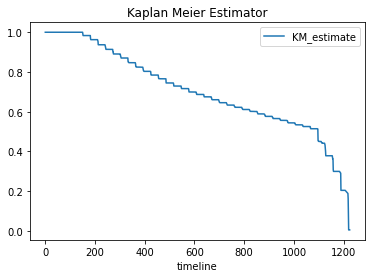

In [ ]:
function.plot(title='Kaplan Meier Estimator')

In [ ]:
model.median_survival_time_

1097.0

In [ ]:
model.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,5906,5906
1.0,2,0,2,0,5906
2.0,4,0,4,0,5904
3.0,3,0,3,0,5900
6.0,2,0,2,0,5897
...,...,...,...,...,...
1217.0,3,3,0,0,39
1218.0,5,5,0,0,36
1219.0,16,16,0,0,31


In [ ]:
df_2006.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,51453366538336630763636,NaN,NaN,2006-08-22,Chargedoff,Not available,2008-05-22,Professional,NaN,True,5833.333333,Not displayed,10000,1,639
1,A3A23365984305581EF2551,NaN,NaN,2006-07-17,Completed,NaN,2009-10-22,NaN,NaN,False,9583.333333,Not displayed,10000,0,1193
2,CB203371350913895324563,NaN,NaN,2006-10-13,Completed,Not available,2007-04-13,Analyst,MO,True,7500.000000,Not displayed,6000,0,182
3,A7AC33650456321694DD117,NaN,NaN,2006-07-21,Completed,Not available,2007-08-10,Executive,MO,True,8583.333333,Not displayed,2200,0,385
4,D8C53374343326309856587,NaN,NaN,2006-11-14,Completed,Not available,2009-03-10,Clerical,NaN,True,1833.333333,Not displayed,5000,0,847


In [ ]:
borrower = (df_2006['IsBorrowerHomeowner'] == True)

T = df_2006.time
E = df_2006.LoanStatus_Censored

model = KaplanMeierFitter()

model.fit(T[borrower], event_observed=E[borrower], label='Homeowner')
fig_1 = model.survival_function_

model.fit(T[~borrower], event_observed=E[~borrower], label='Not Homeowner')
fig_2 = model.survival_function_


figure = pd.concat([fig_1, fig_2], axis=1)
figure.plot(backend='plotly')

In [ ]:
results = logrank_test(T[borrower], T[~borrower], event_observed_A=E[borrower],
                       event_observed_B=E[~borrower])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.36 <0.005     10.38

In [ ]:
def survival(data, group_field, time_field, event_field):
  """
  Funcion que recibe un DataFrame y filtra por columna

  Returns
    gráfica de la función de supervivencia (Survival function)
    Logrank Test
  """

  model = KaplanMeierFitter()
  results = []
  con_exp = []

  for i in data[group_field].dropna().unique():
    group = data[data[group_field] == i]
    T = group[time_field]
    E = group[event_field]
    con_exp.append([T, E])
    model.fit(T, E, label=str(i))
    results.append(model.survival_function_)

  survival = pd.concat(results, axis=1)
  
  
  return survival


In [ ]:
rates = survival(df_2006, 'Occupation', 'time', 'LoanStatus_Censored')
rates.plot(kind='scatter', title='Pago completo dependiendo de su ocupación', 
           backend='plotly')

# Tomando solo en cuenta datos o censurados o personas en Default

In [ ]:
df_cen_def = df_status_clean[(df_status_clean['ClosedDate'] == max_date) | (df_status_clean['LoanStatus_Censored']) == 1]

In [ ]:
df_cen_def.LoanStatus_Censored.value_counts()

0    55176
1    17009
Name: LoanStatus_Censored, dtype: int64

In [ ]:
df_cen_def.ClosedDate.value_counts()

2014-03-10    55183
2013-06-30       37
2009-03-01       34
2009-03-10       33
2014-01-30       32
              ...  
2006-10-05        1
2011-06-07        1
2006-12-08        1
2011-05-30        1
2010-08-12        1
Name: ClosedDate, Length: 2623, dtype: int64

In [ ]:
T_2 = df_cen_def.time
E_2 = df_cen_def.LoanStatus_Censored

model2 = KaplanMeierFitter()

model2.fit(T_2, event_observed=E_2)

function2 = model2.survival_function_

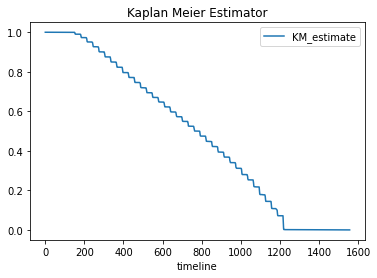

In [ ]:
function2.plot(title='Kaplan Meier Estimator')

In [ ]:
model2.median_survival_time_

775.0

¿Que está pasando?

In [ ]:
# Observemos que datos está utilizando
df_cen_def[df_cen_def['time'] > 1200].LoanStatus_Censored.value_counts()

1    227
0      6
Name: LoanStatus_Censored, dtype: int64

### Cox Model (Segunda Sesión)

In [ ]:
df_2006.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,51453366538336630763636,NaN,NaN,2006-08-22,Chargedoff,Not available,2008-05-22,Professional,NaN,True,5833.333333,Not displayed,10000,1,639
1,A3A23365984305581EF2551,NaN,NaN,2006-07-17,Completed,NaN,2009-10-22,NaN,NaN,False,9583.333333,Not displayed,10000,0,1193
2,CB203371350913895324563,NaN,NaN,2006-10-13,Completed,Not available,2007-04-13,Analyst,MO,True,7500.000000,Not displayed,6000,0,182
3,A7AC33650456321694DD117,NaN,NaN,2006-07-21,Completed,Not available,2007-08-10,Executive,MO,True,8583.333333,Not displayed,2200,0,385
4,D8C53374343326309856587,NaN,NaN,2006-11-14,Completed,Not available,2009-03-10,Clerical,NaN,True,1833.333333,Not displayed,5000,0,847


In [ ]:
to_model = df_2006[['LoanOriginalAmount', 'IsBorrowerHomeowner', 'StatedMonthlyIncome', 
                    'time', 'LoanStatus_Censored']]

In [ ]:
model = CoxPHFitter()
model.fit(to_model, duration_col='time', event_col='LoanStatus_Censored')

<lifelines.CoxPHFitter: fitted with 5906 total observations, 3581 right-censored observations>

In [ ]:
model.print_summary()

<lifelines.CoxPHFitter: fitted with 5906 total observations, 3581 right-censored observations>
             duration col = 'time'
                event col = 'LoanStatus_Censored'
      baseline estimation = breslow
   number of observations = 5906
number of events observed = 2325
   partial log-likelihood = -18423.80
         time fit was run = 2022-04-27 17:52:03 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
LoanOriginalAmount   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IsBorrowerHomeowner  -0.06       0.94       0.05            -0.16             0.03                 0.85                 1.03
StatedMonthlyIncome  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                      cmp to     z      p   -log2(p)
covariate                                           
LoanOriginalAmount      0.00 -0.22   0.82       0.28
IsBorrowerHomeowner     0.00 -1.35   0.18       2.51
StatedMonthlyIncome     0.00 -6.00 <0.005      28.91
---
Concordance = 0.58
Partial AIC = 36853.59
log-likelihood ratio test = 60.40 on 3 df
-log2(p) of ll-ratio test = 40.92

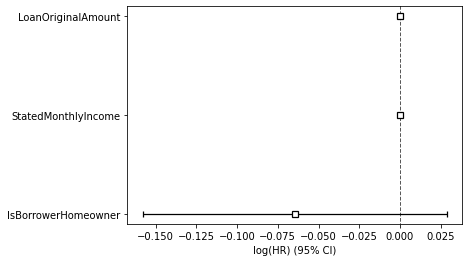

In [ ]:
model.plot()

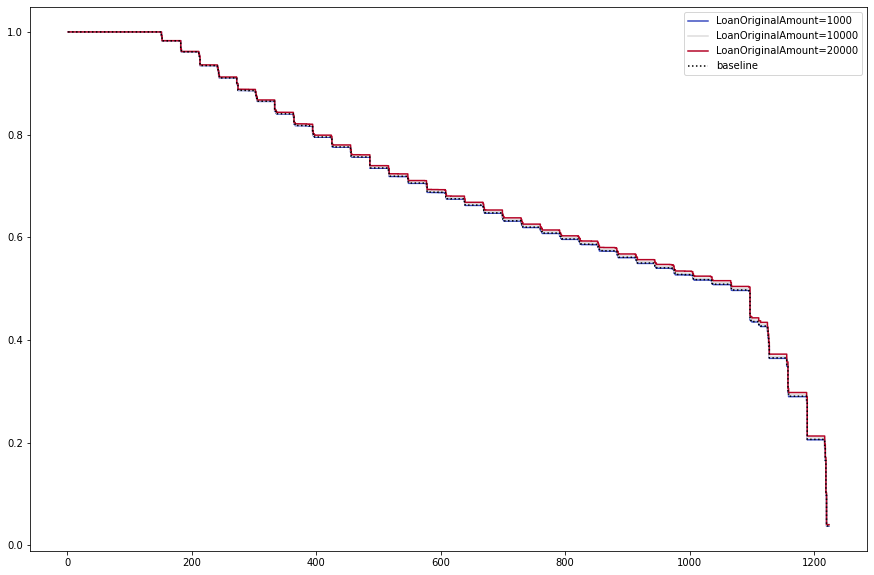

In [ ]:
model.plot_partial_effects_on_outcome(covariates='LoanOriginalAmount',
                                      values=[1000, 10_000, 
                                              20_000], cmap='coolwarm',
                                      figsize=(15, 10))

Prediciendo riesgos

In [ ]:
model.predict_partial_hazard(to_model[:5])

0    0.905750
1    0.816027
2    0.844224
3    0.807628
4    1.090875
dtype: float64

In [ ]:
to_model[['time', 'LoanStatus_Censored']][:5]

,time,LoanStatus_Censored
0,639,1
1,1193,0
2,182,0
3,385,0
4,847,0


### DF filter 2009


In [ ]:
df_2009 = df_status_clean[df_status_clean['LoanOriginationDate'].dt.year == 2009].reset_index(drop=True)
df_2009.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time
0,60B735657994093942AA7B2,6.0,94.0,2009-09-15,Completed,Full-time,2012-09-15,Professional,MD,True,15000.000000,"$100,000+",10000,0,1096
1,06A73569349574436F63BE2,6.0,20.0,2009-10-20,Completed,Full-time,2011-09-30,Accountant/CPA,MD,False,4833.333333,"$50,000-74,999",5000,0,710
2,79D13567170266105A6A095,7.0,259.0,2009-09-22,Completed,Full-time,2010-03-17,Professional,OK,False,4169.333333,"$50,000-74,999",2200,0,176
3,7A3C357134717718161464C,4.0,227.0,2009-11-04,Completed,Full-time,2012-01-13,Administrative Assistant,FL,False,4333.333333,"$50,000-74,999",1500,0,800
4,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669


In [ ]:
df_2009.info()

In [ ]:
# Valores distintos en la columna
df_2009.EmploymentStatus.unique()

array(['Full-time', 'Self-employed', 'Retired', 'Part-time',
       'Not employed'], dtype=object)

In [ ]:
df_2009[['EmploymentStatus']]

,EmploymentStatus
0,Full-time
1,Full-time
2,Full-time
3,Full-time
4,Full-time
...,...
2040,Full-time
2041,Full-time
2042,Full-time
2043,Self-employed


In [ ]:
dummies = pd.get_dummies(df_2009[['EmploymentStatus']], drop_first=True)
dummies.tail()

,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
2040,0,0,0,0
2041,0,0,0,0
2042,0,0,0,0
2043,0,0,0,1
2044,0,0,0,0


In [ ]:
dummies.value_counts()

EmploymentStatus_Not employed  EmploymentStatus_Part-time  EmploymentStatus_Retired  EmploymentStatus_Self-employed
0                              0                           0                         0                                 1832
                                                                                     1                                   87
                               1                           0                         0                                   62
                               0                           1                         0                                   40
1                              0                           0                         0                                   24
dtype: int64

In [ ]:
df_2009.IncomeRange.unique()

array(['$100,000+', '$50,000-74,999', '$25,000-49,999', '$75,000-99,999',
       '$1-24,999', '$0', 'Not employed'], dtype=object)

In [ ]:
def income_range_ordinal(label: str):
  if label in ('$0', 'Not employed'):
    return 0
  elif label == '$1-24,999':
    return 1
  elif label == '$75,000-99,999':
    return 2
  elif label == '$25,000-49,999':
    return 3
  elif label == '$50,000-74,999':
    return 4
  else:
    return 5

In [ ]:
df_2009['IncomeRange_ord'] = df_2009.IncomeRange.apply(income_range_ordinal)

In [ ]:
df_2009.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord
0,60B735657994093942AA7B2,6.0,94.0,2009-09-15,Completed,Full-time,2012-09-15,Professional,MD,True,15000.000000,"$100,000+",10000,0,1096,5
1,06A73569349574436F63BE2,6.0,20.0,2009-10-20,Completed,Full-time,2011-09-30,Accountant/CPA,MD,False,4833.333333,"$50,000-74,999",5000,0,710,4
2,79D13567170266105A6A095,7.0,259.0,2009-09-22,Completed,Full-time,2010-03-17,Professional,OK,False,4169.333333,"$50,000-74,999",2200,0,176,4
3,7A3C357134717718161464C,4.0,227.0,2009-11-04,Completed,Full-time,2012-01-13,Administrative Assistant,FL,False,4333.333333,"$50,000-74,999",1500,0,800,4
4,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669,3


In [ ]:
df_2009_dumm = pd.concat([df_2009, dummies], axis=1)
df_2009_dumm.head()

,LoanKey,ProsperRating (numeric),EmploymentStatusDuration,LoanOriginationDate,LoanStatus,EmploymentStatus,ClosedDate,Occupation,BorrowerState,IsBorrowerHomeowner,StatedMonthlyIncome,IncomeRange,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,60B735657994093942AA7B2,6.0,94.0,2009-09-15,Completed,Full-time,2012-09-15,Professional,MD,True,15000.000000,"$100,000+",10000,0,1096,5,0,0,0,0
1,06A73569349574436F63BE2,6.0,20.0,2009-10-20,Completed,Full-time,2011-09-30,Accountant/CPA,MD,False,4833.333333,"$50,000-74,999",5000,0,710,4,0,0,0,0
2,79D13567170266105A6A095,7.0,259.0,2009-09-22,Completed,Full-time,2010-03-17,Professional,OK,False,4169.333333,"$50,000-74,999",2200,0,176,4,0,0,0,0
3,7A3C357134717718161464C,4.0,227.0,2009-11-04,Completed,Full-time,2012-01-13,Administrative Assistant,FL,False,4333.333333,"$50,000-74,999",1500,0,800,4,0,0,0,0
4,FA0135742712344260C0EC8,7.0,74.0,2009-12-04,Chargedoff,Full-time,2011-10-04,Medical Technician,MD,True,3000.000000,"$25,000-49,999",5000,1,669,3,0,0,0,0


In [ ]:
df_2009_num = df_2009_dumm._get_numeric_data()
df_2009_num.head()

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,6.0,94.0,True,15000.000000,10000,0,1096,5,0,0,0,0
1,6.0,20.0,False,4833.333333,5000,0,710,4,0,0,0,0
2,7.0,259.0,False,4169.333333,2200,0,176,4,0,0,0,0
3,4.0,227.0,False,4333.333333,1500,0,800,4,0,0,0,0
4,7.0,74.0,True,3000.000000,5000,1,669,3,0,0,0,0


In [ ]:
null_col = df_2009_num.isnull().mean()
null_col[null_col > 0]

ProsperRating (numeric)    0.034719
dtype: float64

In [ ]:
df_2009_num.dropna(inplace=True)

In [ ]:
df_2009_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1974 entries, 0 to 2044
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ProsperRating (numeric)         1974 non-null   float64
 1   EmploymentStatusDuration        1974 non-null   float64
 2   IsBorrowerHomeowner             1974 non-null   bool   
 3   StatedMonthlyIncome             1974 non-null   float64
 4   LoanOriginalAmount              1974 non-null   int64  
 5   LoanStatus_Censored             1974 non-null   int64  
 6   time                            1974 non-null   int64  
 7   IncomeRange_ord                 1974 non-null   int64  
 8   EmploymentStatus_Not employed   1974 non-null   uint8  
 9   EmploymentStatus_Part-time      1974 non-null   uint8  
 10  EmploymentStatus_Retired        1974 non-null   uint8  
 11  EmploymentStatus_Self-employed  1974 non-null   uint8  
dtypes: bool(1), float64(3), int64(4), 

In [ ]:
df_2009_num.columns.duplicated()

array([False, False, False, False, False, False, False, False, False,
       False, False, False])

### Cox Model 2009

In [ ]:
to_model = df_2009_num #.iloc[:, 0:10]

In [ ]:
to_model

,ProsperRating (numeric),EmploymentStatusDuration,IsBorrowerHomeowner,StatedMonthlyIncome,LoanOriginalAmount,LoanStatus_Censored,time,IncomeRange_ord,EmploymentStatus_Not employed,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed
0,6.0,94.0,True,15000.000000,10000,0,1096,5,0,0,0,0
1,6.0,20.0,False,4833.333333,5000,0,710,4,0,0,0,0
2,7.0,259.0,False,4169.333333,2200,0,176,4,0,0,0,0
3,4.0,227.0,False,4333.333333,1500,0,800,4,0,0,0,0
4,7.0,74.0,True,3000.000000,5000,1,669,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2040,3.0,29.0,False,6583.333333,7500,1,334,2,0,0,0,0
2041,4.0,104.0,True,5833.333333,1000,1,1187,4,0,0,0,0
2042,4.0,21.0,False,2000.000000,1400,1,638,1,0,0,0,0
2043,1.0,153.0,False,14833.333333,3500,0,49,5,0,0,0,1


In [ ]:
model = CoxPHFitter()
model.fit(df_2009_num, duration_col='time', event_col='LoanStatus_Censored')

model.print_summary()

<lifelines.CoxPHFitter: fitted with 1974 total observations, 1671 right-censored observations>
             duration col = 'time'
                event col = 'LoanStatus_Censored'
      baseline estimation = breslow
   number of observations = 1974
number of events observed = 303
   partial log-likelihood = -1989.53
         time fit was run = 2022-04-27 18:14:55 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
ProsperRating (numeric)         -0.22       0.80       0.03            -0.29            -0.16                 0.75                 0.86
EmploymentStatusDuration         0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
IsBorrowerHomeowner             -0.11       0.89       0.12            -0.36             0.13                 0.70                 1.14
StatedMonthlyIncome             -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
LoanOriginalAmount               0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
IncomeRange_ord                  0.04       1.04       0.06            -0.08             0.17                 0.92                 1.19
EmploymentStatus_Not employed   -0.58       0.56       0.73            -2.02             0.86                 0.13                 2.35
EmploymentStatus_Part-time       0.18       1.20       0.33            -0.47             0.83                 0.62                 2.30
EmploymentStatus_Retired         0.29       1.34       0.39            -0.46             1.05                 0.63                 2.87
EmploymentStatus_Self-employed  -0.18       0.83       0.31            -0.79             0.42                 0.45                 1.53

                                 cmp to     z      p   -log2(p)
covariate                                                      
ProsperRating (numeric)            0.00 -6.61 <0.005      34.63
EmploymentStatusDuration           0.00  1.22   0.22       2.18
IsBorrowerHomeowner                0.00 -0.89   0.37       1.42
StatedMonthlyIncome                0.00 -1.20   0.23       2.11
LoanOriginalAmount                 0.00  2.38   0.02       5.86
IncomeRange_ord                    0.00  0.67   0.50       1.00
EmploymentStatus_Not employed      0.00 -0.80   0.43       1.23
EmploymentStatus_Part-time         0.00  0.54   0.59       0.76
EmploymentStatus_Retired           0.00  0.76   0.45       1.17
EmploymentStatus_Self-employed     0.00 -0.59   0.55       0.85
---
Concordance = 0.65
Partial AIC = 3999.07
log-likelihood ratio test = 54.91 on 10 df
-log2(p) of ll-ratio test = 24.86

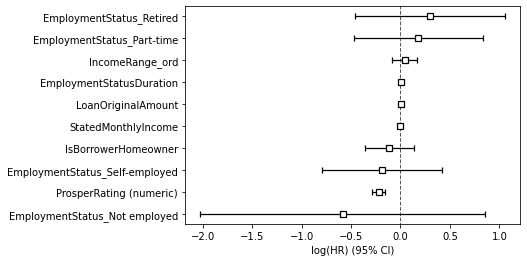

In [ ]:
model.plot()

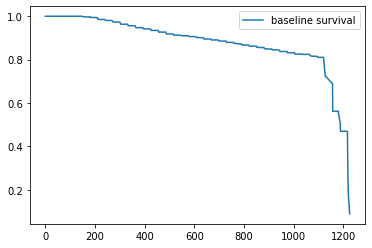

In [ ]:
model.baseline_survival_.plot()

## Caso con estimador paramétrico

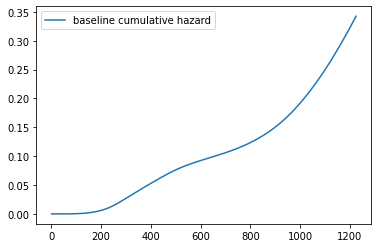

In [ ]:
model = CoxPHFitter(baseline_estimation_method='spline', n_baseline_knots=6)
model.fit(df_2009_num, duration_col='time', event_col='LoanStatus_Censored')

# model.print_summary()
model.baseline_cumulative_hazard_.plot()

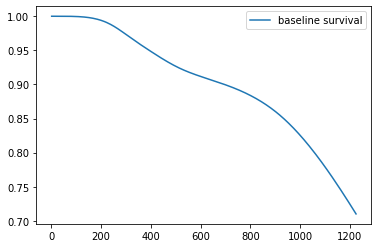

In [ ]:
model.baseline_survival_.plot()

# Random Survival Forest

In [ ]:
!pip install scikit-survival

     |████████████████████████████████| 3.1 MB 11.2 MB/s 


In [ ]:
to_model2 = df_2006[['LoanOriginalAmount', 'StatedMonthlyIncome', 
                  'time', 'LoanStatus_Censored']].copy()

In [ ]:
# Modificación de datos para alimentar el modelo Random Survival Forest
Xt = to_model2[['LoanOriginalAmount', 'StatedMonthlyIncome']]
y = np.array(to_model2[['LoanStatus_Censored', 'time']].apply(tuple, axis=1)).astype([('cens', '?'), ('time', '<f8')])

In [ ]:
to_model2[['LoanStatus_Censored', 'time']]

,LoanStatus_Censored,time
0,1,639
1,0,1193
2,0,182
3,0,385
4,0,847
...,...,...
5901,1,516
5902,0,1080
5903,0,50
5904,1,213


In [ ]:
from sklearn.model_selection import train_test_split

from sksurv.ensemble import RandomSurvivalForest

In [ ]:
random_state = 20

X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [ ]:
y_train

array([(False,   50.), (False, 1096.), (False, 1096.), ...,
       ( True,  244.), ( True,  302.), (False,  738.)],
      dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)
rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [ ]:
# Concordance index
rsf.score(X_train, y_train)

0.6746884732107493

In [ ]:
rsf.score(X_test, y_test)

0.5465702598216362

## Como podemos ver de que servirían las predicciones

In [ ]:
rsf.predict(X_test[100:105])

array([ 50.98321891,  63.70646423,  56.73250439, 116.04888313,
        73.32449617])

In [ ]:
y_test[100:105]

array([(False,  550.), (False,  974.), (False, 1096.), ( True,  386.),
       ( True,  730.)], dtype=[('cens', '?'), ('time', '<f8')])

In [ ]:
X_test[100:105]

,LoanOriginalAmount,StatedMonthlyIncome
1372,3001,8500.000000
3550,2550,10000.000000
2586,3500,6666.666667
2295,2300,2700.000000
3034,1525,583.333333
